#### Importando as bibliotecas

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os
import scipy.stats
from datetime import timedelta
from scipy.stats import wilcoxon
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate
plt.style.use('ggplot')
%matplotlib inline
from tqdm.notebook import tqdm


In [13]:
graficos_dir = r'D:\Trabalho\faculdade\TCC\outputs\graficos\analise_exploratoria'

#### Abrindo os dados

In [14]:
data = pd.read_csv(r'D:\Trabalho\faculdade\TCC\outputs\tabelas\dados_treino_offset.csv')
data['data_medicao'] = pd.to_datetime(data['data_medicao'])
data['lentidao'] = data['lentidao']/1000
data['tamanho_corredor'] = data['tamanho_corredor']/1000

In [15]:
print(datetime.datetime.now())
def get_lentido_historica(x, lag):
    end_date = x['data_medicao'] - timedelta(minutes=30)
    start_date = end_date - timedelta(minutes = lag)
    corredor = x['corredor']
    lentidao_historica = data[(data['corredor']==corredor)& (data['data_medicao']>=start_date) & (data['data_medicao']<=end_date)]['lentidao'].mean()
    if np.isnan(lentidao_historica):
        lentidao_historica = 0
    return lentidao_historica
#data.apply(lambda x: func(x), axis=1)
#lentidao_historica = []
#for idx, row in tqdm(data.iterrows(), total = len(data)):
#    lentidao_historica.append(get_lentido_historica(row))
#lentidao_historica = data.apply(lambda x: get_lentido_historica(x, 180), axis=1)
#print(datetime.datetime.now())


2022-11-02 21:54:00.891112


#### Criando dados de treinamento

In [16]:
data_copy = data[data['precipitacao']>=1]
X = data_copy.set_index(['data_medicao','corredor']).drop(['lentidao',], axis=1)
y = data_copy['lentidao']
x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.85, random_state=42)
#x_train, x_test_and_val, y_train, y_test_and_val = train_test_split(X,y, train_size=0.7)
#x_val, x_test, y_val, y_test = train_test_split(x_test_and_val,y_test_and_val, train_size=0.5)

In [17]:
model = RandomForestRegressor(random_state=42, n_estimators = 500)
#model = MLPRegressor((100,40, 10))
#model = GradientBoostingRegressor(max_depth=10)
#RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

#### Função para gerar métricas  

In [18]:
def get_metrics(y_true, y_pred, save_fig = None):
    df = pd.DataFrame({'true':y_true, 'pred':y_pred}).dropna()
    y_true, y_pred = df['true'].values, df['pred'].values
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true,y_pred)

    print(f'R2: {round(r2,2)}')
    #print(f'MSE:{round(mse_treino,2)}')
    print(f'MAE:{round(mae,2)}')
    print(f'RMSE:{round(rmse,2)}')
    print(f'MAPE: {round(mape,2)}')
    
    fig, ax = plt.subplots(figsize = (8,4))
    ax.scatter(y_true, y_pred, s=7)
    a,b,_,_,_ = scipy.stats.linregress(y_true, y_pred)
    ax.plot(np.arange(1,35), a*np.arange(1,35)+b, c='r')
    ax.set_title('Actual vs Predicted')
    ax.set_ylabel('Predicted slowness (Km)')
    ax.set_xlabel('Actual slowness (Km)')
    if save_fig is not None:
        plt.savefig(os.path.join(graficos_dir, save_fig))
    plt.show()


Grid search CV

In [42]:
from sklearn.model_selection import GridSearchCV
estimator=RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators':[None,200, 500],
    'max_depth':[None, 1, 5, 50],
    'min_samples_split':[None, 2,5,10],
    'min_samples_leaf':[None, 1, 5, 30]
}
validator = GridSearchCV(estimator,
             param_grid=param_grid, cv=sklearn.model_selection.KFold(n_splits=10, shuffle=True))

validator.fit(x_train, y_train)

C:\Users\jefer\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1200 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jefer\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jefer\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "C:\Users\jefer\AppData\Local\ESRI\conda\envs\arc

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 1, 5, 50],
                         'min_samples_leaf': [None, 1, 5, 30],
                         'min_samples_split': [None, 2, 5, 10],
                         'n_estimators': [None, 200, 500]})

cross validation

In [121]:
estimator = RandomForestRegressor(random_state=42)
metrics = sklearn.model_selection.cross_validate(estimator, x_train, y_train, return_train_score=True,
                                       scoring=['r2','neg_mean_absolute_percentage_error','neg_root_mean_squared_error','neg_mean_absolute_error'], cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42))

In [122]:
cross_val_metrics = []
for key in metrics.keys():
    if 'train' in key or 'test' in key:
        cross_val_metrics.append({
            'metric':key,
            'mean':metrics[key].mean(),
            'std':metrics[key].std(),
            '3 x std':3*metrics[key].std()
        })
pd.DataFrame(cross_val_metrics)

,metric,mean,std,3 x std
0,test_r2,0.724155,0.009255,0.027764
1,train_r2,0.895353,0.003558,0.010674
2,test_neg_mean_absolute_percentage_error,-0.439749,0.050088,0.150265
3,train_neg_mean_absolute_percentage_error,-0.241979,0.002305,0.006915
4,test_neg_root_mean_squared_error,-2.182122,0.076581,0.229744
5,train_neg_root_mean_squared_error,-1.344601,0.029846,0.089538
6,test_neg_mean_absolute_error,-0.838882,0.014274,0.042823
7,train_neg_mean_absolute_error,-0.483718,0.005875,0.017624


Métricas de treino

R2: 0.89
MAE:0.48
RMSE:1.35
MAPE: 0.23


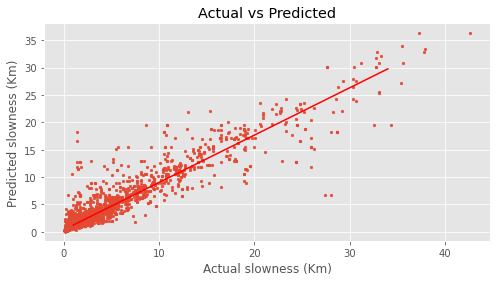

In [19]:
y_pred = model.predict(x_train)
get_metrics(y_train, y_pred, save_fig = os.path.join(graficos_dir, 'treino_previsao.png'))
#plt.savefig(os.path.join(graficos_dir, 'treino_previsao.png'))

Métricas de teste

R2: 0.84
MAE:0.68
RMSE:1.64
MAPE: 0.35


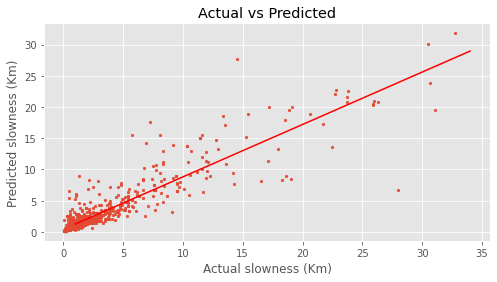

In [20]:
y_pred = model.predict(x_test)
get_metrics(y_test, y_pred, save_fig = os.path.join(graficos_dir, 'teste_previsao.png'))

In [21]:
#y_pred = x_train['lentidao_historica']
#get_metrics(y_train.values, y_pred.values)

Prevendo série temporal (so com dado de test)

Prevendo série temporal (com todo dataset)

In [22]:
#model = RandomForestRegressor()
#model.fit(X,y)
#corredor = 'Marginal Tietê'
corredor = 'Marginal Pinheiros'

start_date = pd.to_datetime('2019-02-01 07:30:00')
end_date = pd.to_datetime('2019-02-28 23:59:00')
x_test_corredor = data.copy()
x_test_corredor = x_test_corredor[(x_test_corredor['corredor']==corredor) & (x_test_corredor['data_medicao']>=start_date) & (x_test_corredor['data_medicao']<=end_date)].sort_values('data_medicao')
x_test_corredor = x_test_corredor.set_index(['data_medicao','corredor'])
y_test_corredor = x_test_corredor['lentidao']
x_test_corredor = x_test_corredor.drop('lentidao', axis=1)
y_pred_corredor = model.predict(x_test_corredor)

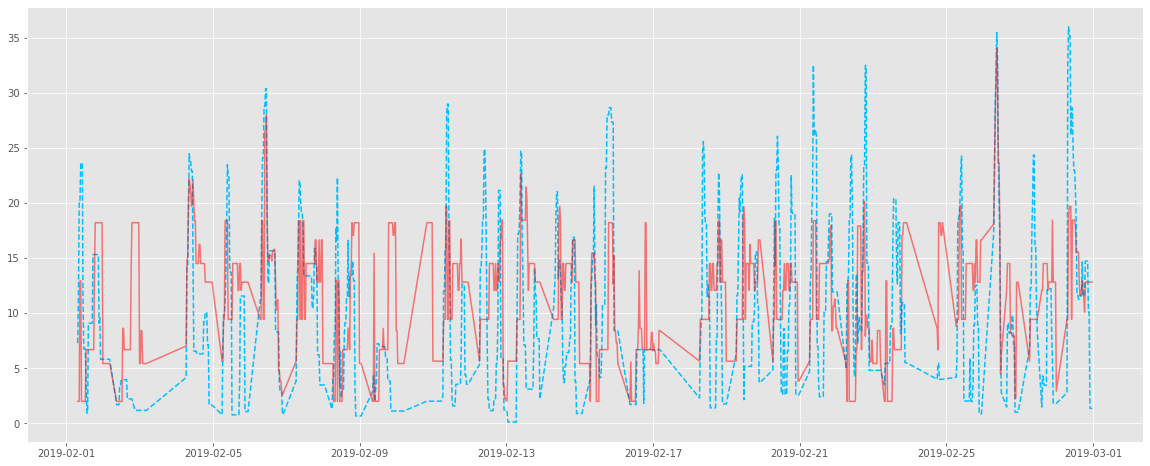

In [23]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(x_test_corredor.reset_index()['data_medicao'], y_test_corredor, linestyle='--',  c='deepskyblue')
ax.plot(x_test_corredor.reset_index()['data_medicao'], y_pred_corredor, linestyle='-', c='r', alpha=0.5)
plt.show()

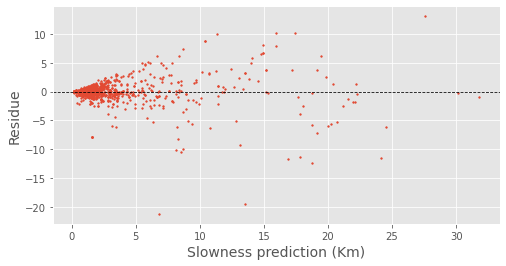

In [15]:
#Homocedasticidade
residuos = y_pred - y_test
fig, ax = plt.subplots(figsize = (8,4))
ax.scatter(y_pred, residuos, s=3)
ax.axhline(y=0, c='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Slowness prediction (Km)', fontsize=14)
ax.set_ylabel('Residue', fontsize= 14)
plt.savefig(os.path.join(graficos_dir,'homocedasticidade.png'))
plt.show()

### Dummy models

#### Always predicts the mean

In [16]:
from sklearn.dummy import DummyRegressor
dummy_reg = DummyRegressor()
dummy_reg.fit(x_train, y_train)
y_pred_dummy_a = dummy_reg.predict(x_train)
get_metrics(y_train, y_pred, save_fig = os.path.join(graficos_dir, 'dummy_mean.png'))


ValueError: array length 1528 does not match index length 6109

#### Always predicts the mean for that road

R2: 0.52
MAE:1.36
RMSE:2.94
MAPE: 0.85


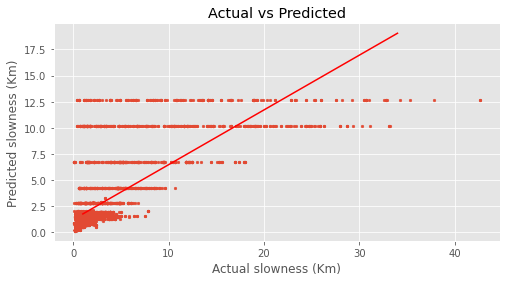

In [213]:
class DummyRegressor:
    def __init__(self, method):
        self.method = method
    
    def fit(self,x_train, y_train):
        x_train = x_train.reset_index()
        x_train['lentidao'] = y_train.values
        #x_train['hour'] = x_train['data_medicao'].dt.hour
        if self.method == 'corredor':
            x_train = x_train.set_index(['corredor'])
        elif self.method == 'day':
            x_train['day'] = x_train['data_medicao'].dt.day
            x_train = x_train.set_index(['day'])
        self.x_fitted = x_train
        
    def predict(self, x):
        x = x.reset_index()
        #x['hour'] = x['data_medicao'].dt.hour
        if self.method == 'corredor':
            x = x.set_index(['corredor'])
        elif self.method == 'day':
            x['day'] = x['data_medicao'].dt.day
            x = x.set_index('day')

        predictions = []
        
        for idx, row in x.iterrows():
            try:
                predictions.append(self.x_fitted.loc[idx]['lentidao'].mean())
            except KeyError:
                predictions.append(np.nan)
        return predictions

dummy = DummyRegressor('corredor')
dummy.fit(x_train, y_train)

y_pred = dummy.predict(x_train)
get_metrics(y_train, y_pred, save_fig = os.path.join(graficos_dir, 'dummy_mean_road.png'))

#### Always predicts the mean for that day

R2: 0.01
MAE:2.4
RMSE:4.23
MAPE: 2.15


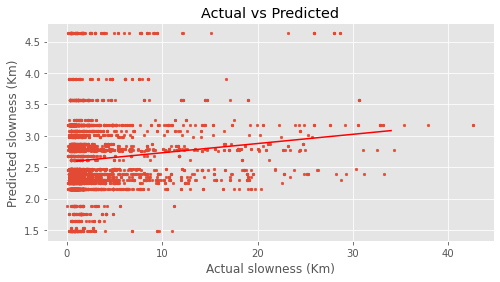

In [214]:
dummy = DummyRegressor('day')
dummy.fit(x_train, y_train)

y_pred = dummy.predict(x_train)
get_metrics(y_train, y_pred, save_fig = os.path.join(graficos_dir, 'dummy_mean_day.png'))

##### Importância das features

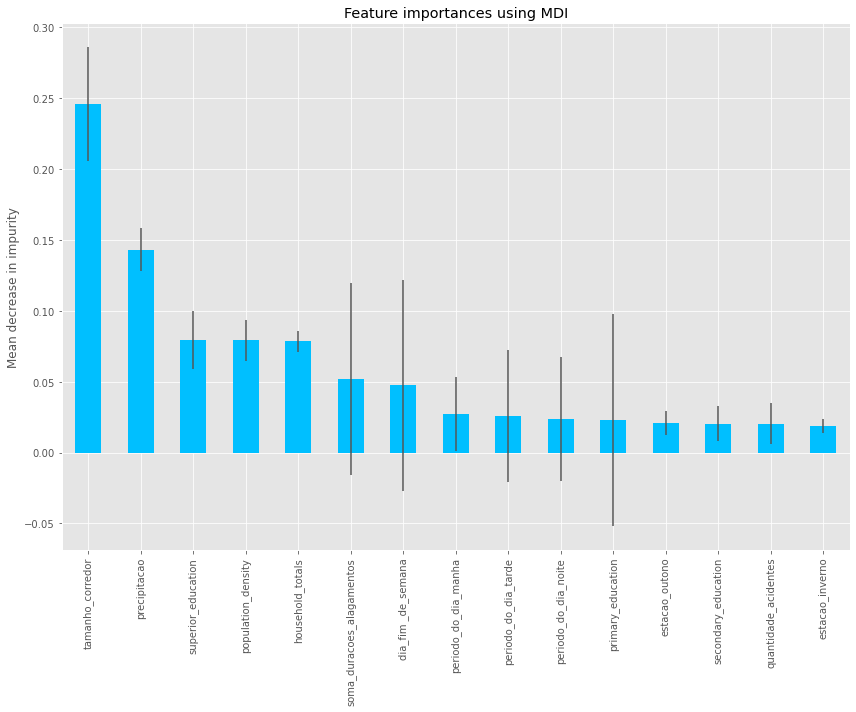

In [64]:
importances = model.feature_importances_
feature_names = x_train.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:15]

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(12,10))
forest_importances.plot.bar(yerr=std[:15], ax=ax, color='deepskyblue')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()